## Trading env

In [1]:
import pandas as pd
import gymnasium as gym
from gym_trading_env.renderer import Renderer

In [2]:
# Available in the github repo : examples/data/BTC_USD-Hourly.csv
url = "https://raw.githubusercontent.com/ClementPerroud/Gym-Trading-Env/main/examples/data/BTC_USD-Hourly.csv"
df = pd.read_csv(url, parse_dates=["date"], index_col= "date")
df.sort_index(inplace= True)
df.dropna(inplace= True)
df.drop_duplicates(inplace=True)
df.head()

,unix,symbol,open,high,low,close,volume,Volume USD
date,,,,,,,,
2018-05-15 06:00:00,1526364000,BTC/USD,8733.86,8796.68,8707.28,8740.99,4906603.14,559.93
2018-05-15 07:00:00,1526367600,BTC/USD,8740.99,8766.00,8721.11,8739.00,2390398.89,273.58
2018-05-15 08:00:00,1526371200,BTC/USD,8739.00,8750.27,8660.53,8728.49,7986062.84,917.79
2018-05-15 09:00:00,1526374800,BTC/USD,8728.49,8754.40,8701.35,8708.32,1593991.98,182.62
2018-05-15 10:00:00,1526378400,BTC/USD,8708.32,8865.00,8695.11,8795.90,11101273.74,1260.69


In [3]:
df = df.iloc[0:1000]

In [ ]:
# df is a DataFrame with columns : "open", "high", "low", "close", "Volume USD"

# Create the feature : ( close[t] - close[t-1] )/ close[t-1]
df["feature_close"] = df["close"].pct_change()

# Create the feature : open[t] / close[t]
df["feature_open"] = df["open"]/df["close"]

# Create the feature : high[t] / close[t]
df["feature_high"] = df["high"]/df["close"]

# Create the feature : low[t] / close[t]
df["feature_low"] = df["low"]/df["close"]

 # Create the feature : volume[t] / max(*volume[t-7*24:t+1])
df["feature_volume"] = df["Volume USD"] / df["Volume USD"].rolling(7*24).max()

df.dropna(inplace= True) # Clean again !
# Each step, the environment will return 5 inputs  : "feature_close", "feature_open", "feature_high", "feature_low", "feature_volume"
df.head()

,unix,symbol,open,high,low,close,volume,Volume USD,feature_close,feature_open,feature_high,feature_low,feature_volume
date,,,,,,,,,,,,,
2018-05-22 05:00:00,1526965200,BTC/USD,8285.29,8314.32,8261.52,8280.00,1711668.56,206.40,-0.000638,1.000639,1.004145,0.997768,0.120688
2018-05-22 06:00:00,1526968800,BTC/USD,8280.00,8355.97,8280.00,8317.02,2975233.66,357.53,0.004471,0.995549,1.004683,0.995549,0.209057
2018-05-22 07:00:00,1526972400,BTC/USD,8317.02,8333.49,8297.00,8320.16,893167.95,107.43,0.000378,0.999623,1.001602,0.997216,0.062817
2018-05-22 08:00:00,1526976000,BTC/USD,8320.16,8325.60,8290.00,8295.90,968758.33,116.54,-0.002916,1.002924,1.003580,0.999289,0.068144
2018-05-22 09:00:00,1526979600,BTC/USD,8295.90,8296.01,8220.00,8245.47,3954060.34,479.07,-0.006079,1.006116,1.006129,0.996911,0.280125


In [5]:
env = gym.make("TradingEnv",
        name= "BTCUSD",
        df = df, # Your dataset with your custom features
        positions = [ -1, 0, 1], # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
    )

In [6]:
# Run an episode until it ends :
done, truncated = False, False
observation, info = env.reset()
while not done and not truncated:
    # Pick a position by its index in your position list (=[-1, 0, 1])....usually something like : position_index = your_policy(observation)
    position_index = env.action_space.sample() # At every timestep, pick a random position index from your position list (=[-1, 0, 1])
    observation, reward, done, truncated, info = env.step(position_index)

# At the end of the episode you want to render
env.save_for_render(dir = "render_logs")

Market Return : -24.41%   |   Portfolio Return : 31.33%   |   


In [7]:
renderer = Renderer(render_logs_dir="render_logs")
# Add Custom Metrics (Annualized metrics)
renderer.add_metric(
    name = "Annual Market Return",
    function = lambda df : f"{ ((df['close'].iloc[-1] / df['close'].iloc[0])**(pd.Timedelta(days=365)/(df.index.values[-1] - df.index.values[0]))-1)*100:0.2f}%"
)
renderer.add_metric(
        name = "Annual Portfolio Return",
        function = lambda df : f"{((df['portfolio_valuation'].iloc[-1] / df['portfolio_valuation'].iloc[0])**(pd.Timedelta(days=365)/(df.index.values[-1] - df.index.values[0]))-1)*100:0.2f}%"
)

renderer.run()

 * Serving Flask app 'gym_trading_env.renderer'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [15/Jan/2026 11:29:49] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [15/Jan/2026 11:29:52] "GET /update_data/BTCUSD_2026-01-15_11-29-25.pkl HTTP/1.1" 200 -
127.0.0.1 - - [15/Jan/2026 11:29:52] "GET /metrics HTTP/1.1" 200 -


## Training agent

In [41]:
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from itertools import count
%matplotlib inline

In [42]:
env = gym.make("TradingEnv",
        name= "BTCUSD",
        df = df, # Your dataset with your custom features
        positions = [ -1, 0, 1], # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
    )

In [43]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

In [44]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [45]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [46]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer

BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.01
EPS_DECAY = 2500
TAU = 0.005
LR = 3e-4


# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)
initial_portfolio_value = info["portfolio_valuation"]

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_returns = []


def plot_returns(show_result=False):
    plt.figure(1)
    returns_t = torch.tensor(episode_returns, dtype=torch.float32)

    if show_result:
        plt.title('Final Result')
    else:
        plt.clf()
        plt.title('Training Performance')

    plt.xlabel('Episode')
    plt.ylabel('Portfolio Return')

    plt.plot(returns_t.numpy(), label="Episode Return")

    # Moving average (optional but highly recommended)
    if len(returns_t) >= 10:
        means = returns_t.unfold(0, 10, 1).mean(1)
        means = torch.cat((torch.zeros(9), means))
        plt.plot(means.numpy(), label="10-episode MA")

    plt.legend()
    plt.pause(0.001)

    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


In [47]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Complete
Episode 1: return = -1.4992%
Episode 2: return = -13.5553%
Episode 3: return = -8.6893%
Episode 4: return = -12.4708%
Episode 5: return = -12.8953%
Episode 6: return = 0.7965%
Episode 7: return = 12.8717%
Episode 8: return = -12.6262%
Episode 9: return = 2.5944%
Episode 10: return = 6.2969%
Episode 11: return = 63.1030%
Episode 12: return = -0.6177%
Episode 13: return = 42.1074%
Episode 14: return = 22.7803%
Episode 15: return = 1.8474%
Episode 16: return = 50.3000%
Episode 17: return = 34.2232%
Episode 18: return = 29.7860%
Episode 19: return = 47.0204%
Episode 20: return = 32.8341%
Episode 21: return = 94.2406%
Episode 22: return = 43.5260%
Episode 23: return = 68.9412%
Episode 24: return = 57.9120%
Episode 25: return = 25.0371%
Episode 26: return = 47.2752%
Episode 27: return = 62.3657%
Episode 28: return = 38.8051%
Episode 29: return = 49.1913%
Episode 30: return = 40.9520%


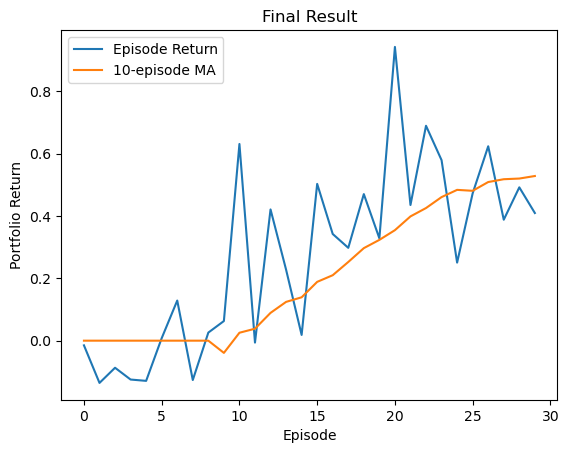

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [53]:
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 5
else:
    num_episodes = 4

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, info = env.step(action.item())
        current_portfolio_value = info["portfolio_valuation"]
        reward = torch.tensor([reward], device=device, dtype=torch.float32)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_return = (current_portfolio_value / initial_portfolio_value) - 1
            print(f"Episode {i_episode + 1}: return = {episode_return:.4%}")
            episode_returns.append(episode_return)
            plot_returns()
            break

print('Complete')
for i, r in enumerate(episode_returns, start=1):
    print(f"Episode {i}: return = {r:.4%}")
plot_returns(show_result=True)
plt.ioff()
plt.show()

In [54]:
torch.save(policy_net.state_dict(), "trading_dqn.pth")

## Evaluation

In [55]:
# Available in the github repo : examples/data/BTC_USD-Hourly.csv
url = "https://raw.githubusercontent.com/ClementPerroud/Gym-Trading-Env/main/examples/data/BTC_USD-Hourly.csv"
new_df = pd.read_csv(url, parse_dates=["date"], index_col= "date")
new_df.sort_index(inplace= True)
new_df.dropna(inplace= True)
new_df.drop_duplicates(inplace=True)

new_df = new_df.iloc[1001:2000]

# new_df is a DataFrame with columns : "open", "high", "low", "close", "Volume USD"

# Create the feature : ( close[t] - close[t-1] )/ close[t-1]
new_df["feature_close"] = new_df["close"].pct_change()

# Create the feature : open[t] / close[t]
new_df["feature_open"] = new_df["open"]/new_df["close"]

# Create the feature : high[t] / close[t]
new_df["feature_high"] = new_df["high"]/new_df["close"]

# Create the feature : low[t] / close[t]
new_df["feature_low"] = new_df["low"]/new_df["close"]

# Create the feature : volume[t] / max(*volume[t-7*24:t+1])
new_df["feature_volume"] = new_df["Volume USD"] / new_df["Volume USD"].rolling(7*24).max()

new_df.dropna(inplace= True) # Clean again !
# Each step, the environment will return 5 inputs  : "feature_close", "feature_open", "feature_high", "feature_low", "feature_volume"
new_df.head()

,unix,symbol,open,high,low,close,volume,Volume USD,feature_close,feature_open,feature_high,feature_low,feature_volume
date,,,,,,,,,,,,,
2018-07-02 22:00:00,1530568800,BTC/USD,6637.16,6643.66,6608.26,6614.26,1974342.04,298.29,-0.003450,1.003462,1.004445,0.999093,0.108068
2018-07-02 23:00:00,1530572400,BTC/USD,6614.26,6623.30,6593.86,6612.98,1536430.53,232.72,-0.000194,1.000194,1.001561,0.997109,0.084312
2018-07-03 00:00:00,1530576000,BTC/USD,6612.98,6620.55,6592.33,6609.19,983365.37,148.93,-0.000573,1.000573,1.001719,0.997449,0.053956
2018-07-03 01:00:00,1530579600,BTC/USD,6609.19,6616.36,6602.65,6612.02,683852.60,103.48,0.000428,0.999572,1.000656,0.998583,0.037490
2018-07-03 02:00:00,1530583200,BTC/USD,6612.02,6638.01,6607.91,6622.44,1229967.86,185.82,0.001576,0.998427,1.002351,0.997806,0.067321


In [56]:
eval_env = gym.make(
    "TradingEnv",
    name="BTCUSD_EVAL",
    df=new_df,
    positions=[-1, 0, 1],
    trading_fees=0.01 / 100,
    borrow_interest_rate=0.0003 / 100,
)

In [57]:
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

# Get env dimensions
state, info = eval_env.reset()
n_observations = len(state)
n_actions = eval_env.action_space.n

# Rebuild model
policy_net = DQN(n_observations, n_actions).to(device)
policy_net.load_state_dict(torch.load("trading_dqn.pth", map_location=device))
policy_net.eval()  # evaluation mode

FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

In [61]:
episodes = 5
episode_returns = []

for ep in range(episodes):
    state, info = eval_env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    initial_value = info["portfolio_valuation"]

    done = False
    while not done:
        with torch.no_grad():
            action = policy_net(state).argmax(dim=1).item()

        observation, reward, terminated, truncated, info = eval_env.step(action)
        done = terminated or truncated

        if not done:
            state = torch.tensor(
                observation,
                dtype=torch.float32,
                device=device
            ).unsqueeze(0)

    final_value = info["portfolio_valuation"]
    episode_return = (final_value / initial_value) - 1
    episode_returns.append(episode_return)

    print(f"Eval Episode {ep + 1}: return = {episode_return:.2%}")


Market Return :  4.66%   |   Portfolio Return :  0.00%   |   
Eval Episode 1: return = 0.00%
Market Return :  4.66%   |   Portfolio Return : -0.01%   |   
Eval Episode 2: return = -0.01%
Market Return :  4.66%   |   Portfolio Return : -0.01%   |   
Eval Episode 3: return = -0.01%
Market Return :  4.66%   |   Portfolio Return :  0.00%   |   
Eval Episode 4: return = 0.00%
Market Return :  4.66%   |   Portfolio Return : -0.01%   |   
Eval Episode 5: return = -0.01%


overfitting to training data, not generalizing to test data